In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import multivariate_normal
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm, trange
import time # to be used in loop iterations
np.random.seed(1234)

In [2]:
def sigmoid(x):
    if x < 0:
        return np.exp(x)/(1+np.exp(x))
    else:
        return 1/(1+np.exp(-x))
vsigmoid = np.vectorize(sigmoid)   

In [3]:
#standardising dataset
def standardise_mlp(X):
    """
    Args:

    X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:

    Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xstd = ((X-mu)/std_filled)
    return Xstd

In [6]:
# Load training data 

#train data
data = pd.read_csv('MNIST_train.csv')

#training set ground truth labels
y_train = np.squeeze(np.array(data[data.columns[0]]))

train_data = data[data.columns[1:]].to_numpy()

#standardise train data
train_data_std = standardise_mlp(train_data)

#test data
test_data = pd.read_csv('MNIST_test.csv')

#test set ground truth labels
y_test = np.array(test_data[test_data.columns[0]])

test_data = test_data[test_data.columns[1:]].to_numpy()

#standardise test data
test_data_std = standardise_mlp(test_data)


x_train = train_data_std
y_train = np.where(y_train == 0,  1, -1)
x_test = test_data_std
y_test = np.where(y_test == 0,  1, -1)

In [7]:
def neural_net(x,w,c):
    #shape of x: (n,d)
    #shape of w: (N,d)
    #shape of c: (1, N)
    n = x.shape[0]
    d = x.shape[1]
    N = w.shape[0]
    return (1/N*c@vsigmoid(w@x.T)).reshape(1,n)

In [64]:
def train(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-2):
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    
    #sgd - update weights (using KL loss)
    count = 1
    
    for x,y in tqdm(zip(x_train,y_train)):
        y = y.reshape(1,-1)
        x = x.reshape(1,-1)
        f = neural_net(x,w,c).reshape(1,-1)
        s = vsigmoid(w@x.T)
        dw = 1/N * ((f-y)@c).T*(s*(1-s))*x
        dc = 1/N * (f-y).T*s.reshape(1,-1)
        w -= learning_rate*dw
        c -= learning_rate*dc
        
        if  count in [1, 10 , 100] + list((10**np.linspace(3, 4.7, 20)).astype(int)): 
            f_test = neural_net(x_test,w,c).reshape(-1,1)
            y_test = y_test.reshape(-1,1)
            loss = 0.5*np.mean((f_test-y_test)**2)
            print('Epoch count: {}, Loss: {}'.format(count, loss))
            losses.append(loss)
        
        count += 1 
        
    return c, w, np.ndarray.flatten(c), losses

In [109]:
def nesterov_train(x_train, y_train, x_test, y_test, N = 100, r = 3, learning_rate = 1e-2):
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    w_change = w
    c_change = c
    
    count = 1
    
    for x,y in tqdm(zip(x_train,y_train)):
        y = y.reshape(1,-1)
        x = x.reshape(1,-1)
        f = neural_net(x,w_change,c_change).reshape(1,-1)
        s = vsigmoid(w_change@x.T)
        dw = 1/N * ((f-y)@c_change).T*(s*(1-s))*x
        dc = 1/N * (f-y).T*s.reshape(1,-1)
        w1 = w
        c1 = c
        
        if  count in [1, 10 , 100] + list((10**np.linspace(3, 4.7, 20)).astype(int)): 
            f_test = neural_net(x_test,w,c).reshape(-1,1)
            y_test = y_test.reshape(-1,1)
            loss = 0.5*np.mean((f_test-y_test)**2)
            print('Epoch count: {}, Loss: {}'.format(count, loss))
            losses.append(loss)
         
        
        w_new = w_change - learning_rate*dw
        c_new = c_change - learning_rate*dc
        w_change = w_new + 0.9*(w_new-w1) 
        c_change = c_new + 0.9*(c_new-c1) 
        w = w_new
        c = c_new
        
        count += 1
        
    return c, w, np.ndarray.flatten(c), losses

In [192]:
def Hom_SGLD(x_train, y_train, x_test, y_test, N = 100,  M = 20, λ = 10, learning_rate = 1e-3):

    #initialise Params
    d = x_train.shape[1]
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    
    #initialise fast time scale variables Y as a numpy matrix with dimensions (num_epochs, N, M)
    Y_w = np.zeros((M+1, N, d))
    Y_c = np.zeros((M+1, N))
    
    losses = []
    
    count = 1
    
    for x,y in tqdm(zip(x_train,y_train)):
        y = y.reshape(1,-1)
        x = x.reshape(1,-1)

        #update Y
        Y_w_1 = np.zeros((M+1, N, d))
        Y_c_1 = np.zeros((M+1, N))
        Y_w_1[0, :, :] = Y_w[-1, :, :] 
        Y_c_1[0, :] = Y_c[-1, :]

        for m in range(1,M+1):
            δ = 0.01/20
            γ = 0.1
            β = 10
            f = neural_net(x, Y_w_1[m-1, :, :].reshape((N,d)),  Y_c_1[m-1, :].reshape((1,N)))
            s = vsigmoid(Y_w_1[m-1, :, :].reshape((N,d))@x.T)
            dw = 1/N * ((f-y)@Y_c_1[m-1,:].reshape(1,N)).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)

            Y_w_1[m, :,:] = Y_w_1[m-1, : ,:] - δ*(dw-(1/γ)*(w-Y_w_1[m-1, :, :]))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1,(N,d))
            Y_c_1[m, :] = Y_c_1[m-1,:] - δ*(dc-(1/γ)*(c-Y_c_1[m-1, :]))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1,N)

        Y_w[0, :, :] = Y_w_1[-1, :, :]
        Y_c[0, :] = Y_c_1[-1, :]


        cal_Y_w = np.mean(Y_w_1, axis = 0)
        cal_Y_c = np.mean(Y_c_1, axis = 0)


        #update model parameters
        Δ = learning_rate
        X = np.hstack((w, c.T))
        mu = np.mean(X, axis = 1).reshape(1,N)
        w = w - 1/γ*(w-cal_Y_w)*Δ - λ*(w - mu.T)*Δ
        c = c - 1/γ*(c-cal_Y_c)*Δ - λ*(c - mu)*Δ

        if  count in [1, 10, 100] + list((10**np.linspace(3, 4.5, 20)).astype(int)): 
            f_test = neural_net(x_test,w,c).reshape(-1,1)
            y_test = y_test.reshape(-1,1)
            loss = 0.5*np.mean((f_test-y_test)**2)
            print('Epoch count: {}, Loss: {}'.format(count, loss))
            losses.append(loss)

        count+=1
                
    return w, c, np.ndarray.flatten(c), np.array(losses)

In [184]:
#simulate HomSGLD

weights_HomSGLD, c_HomSGLD, params_HomSGLD, risk_HomSGLD,  =\
Hom_SGLD(x_train, y_train, x_test, y_test, N = 200, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 656.920969300456
Epoch count: 10, Loss: 8957.013424392215
Epoch count: 50, Loss: 3623.8857420574923
Epoch count: 100, Loss: 531.2861058345605
Epoch count: 1000, Loss: 0.5000379587351085
Epoch count: 1228, Loss: 0.5000062783812412
Epoch count: 1509, Loss: 0.5000007519053771
Epoch count: 1855, Loss: 0.5000514131129237
Epoch count: 2279, Loss: 0.4999481795903028
Epoch count: 2801, Loss: 0.5000195406737393
Epoch count: 3442, Loss: 0.4999680929702288
Epoch count: 4229, Loss: 0.5000276035905076
Epoch count: 5197, Loss: 0.4999926713005714
Epoch count: 6386, Loss: 0.500012903725184
Epoch count: 7847, Loss: 0.49999935312082167
Epoch count: 9642, Loss: 0.5000365935550742
Epoch count: 11849, Loss: 0.4999763172669232
Epoch count: 14559, Loss: 0.4999782651976797
Epoch count: 17890, Loss: 0.4999902275055795
Epoch count: 21983, Loss: 0.5000361262384013
Epoch count: 27013, Loss: 0.5000657020088259
Epoch count: 33193, Loss: 0.4999467723229269
Epoch count: 40787, Loss: 0.5000210170

In [187]:
c, w, params, risk_SGD = train(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 1375.748244523452
Epoch count: 10, Loss: 1991.975920023121
Epoch count: 100, Loss: 838.1252173346121
Epoch count: 1000, Loss: 243.82441409740775
Epoch count: 1228, Loss: 233.6584786585303
Epoch count: 1509, Loss: 192.66583811663165
Epoch count: 1855, Loss: 167.77158615896587
Epoch count: 2279, Loss: 157.56736683720953
Epoch count: 2801, Loss: 148.53302474349184
Epoch count: 3442, Loss: 128.11190035681383
Epoch count: 4229, Loss: 118.90360894481204
Epoch count: 5197, Loss: 114.7107754376242
Epoch count: 6386, Loss: 103.77031746072726
Epoch count: 7847, Loss: 103.53498055331077
Epoch count: 9642, Loss: 92.6854179984925
Epoch count: 11849, Loss: 90.56921996634574
Epoch count: 14559, Loss: 85.17131246015782
Epoch count: 17890, Loss: 81.92649904364225
Epoch count: 21983, Loss: 78.34374385032342
Epoch count: 27013, Loss: 75.603159850877
Epoch count: 33193, Loss: 70.82584165782184
Epoch count: 40787, Loss: 69.16086256448652
Epoch count: 50118, Loss: 64.14294125641159


In [188]:
c, w, params_NSGD, risk_NSGD = nesterov_train(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 406.3524977166169
Epoch count: 10, Loss: 2443.047987379032
Epoch count: 100, Loss: 634.4378476333052
Epoch count: 1000, Loss: 171.67665197292018
Epoch count: 1228, Loss: 163.12415241336424
Epoch count: 1509, Loss: 149.12713581931064
Epoch count: 1855, Loss: 141.02671428168262
Epoch count: 2279, Loss: 139.19011191733588
Epoch count: 2801, Loss: 125.90457010430005
Epoch count: 3442, Loss: 118.70078769376069
Epoch count: 4229, Loss: 112.38738414762618
Epoch count: 5197, Loss: 120.54052688575334
Epoch count: 6386, Loss: 116.50069993960591
Epoch count: 7847, Loss: 113.15885304549546
Epoch count: 9642, Loss: 111.35470541017787
Epoch count: 11849, Loss: 110.1170930131302
Epoch count: 14559, Loss: 105.90591369772869
Epoch count: 17890, Loss: 105.80806764168898
Epoch count: 21983, Loss: 102.25099406783748
Epoch count: 27013, Loss: 102.75523302037114
Epoch count: 33193, Loss: 99.91470289759063
Epoch count: 40787, Loss: 96.4752989120979
Epoch count: 50118, Loss: 95.345464776

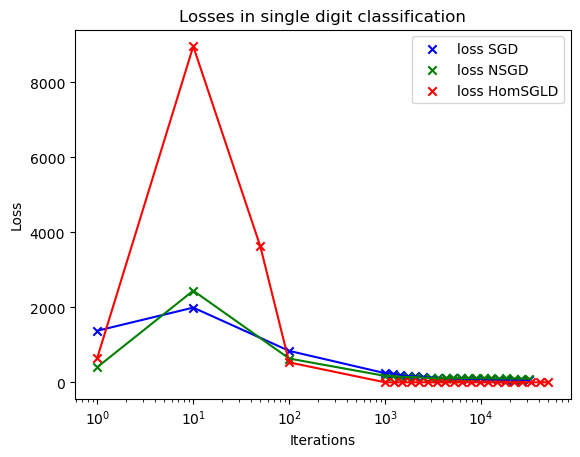

In [191]:
#plot SGD losses vs Nesterov accelerated SGD losses
indices = [1, 10 , 100] + list((10**np.linspace(3, 4.5, 20)).astype(int))
indices_hom = [1, 10, 50, 100] + list((10**np.linspace(3, 4.7, 20)).astype(int))
fig, ax = plt.subplots()
ax.plot(indices, risk_SGD, c = 'b')
ax.plot(indices, risk_NSGD, c = 'g')
ax.plot(indices_hom, risk_HomSGLD, c = 'r')
ax.scatter(indices, risk_SGD, marker = 'x', c = 'b', label = 'loss SGD')
ax.scatter(indices, risk_NSGD, marker = 'x', c = 'g', label = 'loss NSGD')
ax.scatter(indices_hom, risk_HomSGLD, marker = 'x', c = 'r', label = 'loss HomSGLD')

ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Losses in single digit classification')
ax.legend()
plt.show()

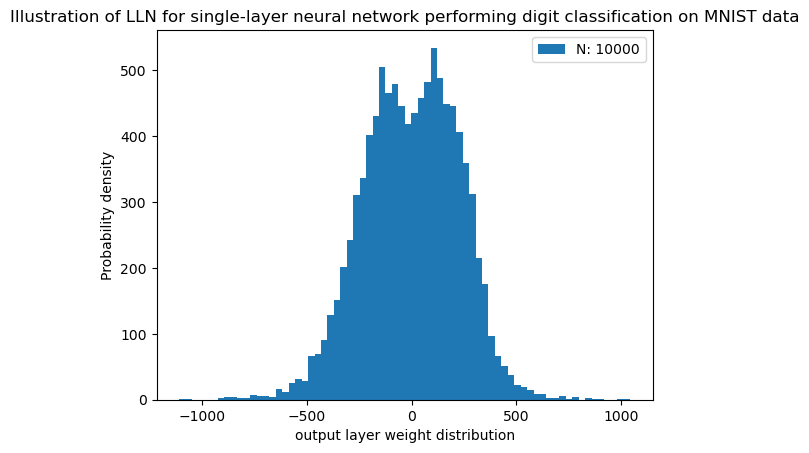

In [43]:
plt.hist(params, label = 'N: 10000', bins = 70)
plt.title('Illustration of LLN for single-layer neural network performing digit classification on MNIST data')
plt.ylabel('Probability density')
plt.xlabel('output layer weight distribution')
plt.legend()